U-Net: Convolutional Networks for Biomedical Image Segmentation

U-Net은 Biomedical 분야에서 이미지 분할(Image Segmentation)을 목적으로 제안된 End-to-End 방식의 Fully-Convolutional Network 기반 모델이다

목적 : 의료 이미지 분석을 위해 만듬

U-Net의 이름 유래 : U모양의 대칭 구조를 갖고 있어서

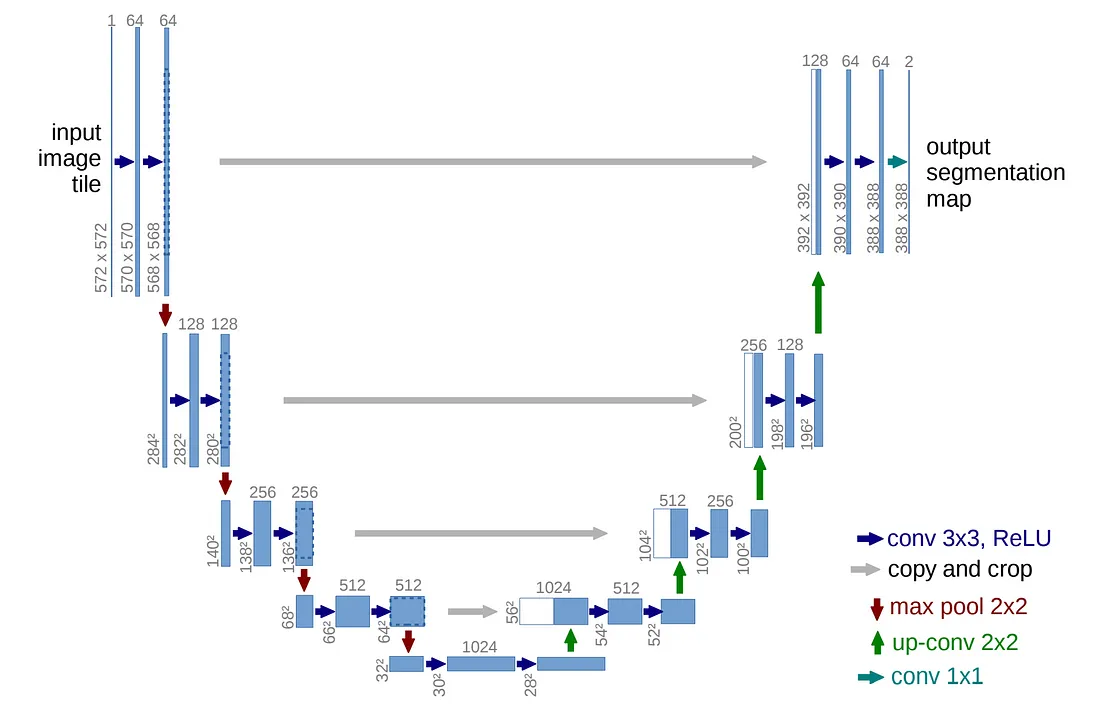

이 구조는 2개의 부분으로 구성됨

- 축소 경로 (Contracting Path): 왼쪽 부분이며, 전형적인 CNN구조
- 확장 경로 (Expanding Path): 오른쪽 경로, 업 샘플링, 컨벌루션 등을 통해 이미지를 원래 크기로 복원함

U-Net은 FCN(Fully convolutional network)을 토대로 확장한 개념이기 때문에 명확한 이해를 돕기 위해 우선적으로 FCN을 이해하는 것이 바람직하다.

Coarse Map(중간에 만들어지는 작은 사이즈의 FeatureMap) to Dense Map(고 해상도의 사이즈를 갖는 마지막 계열 맵)

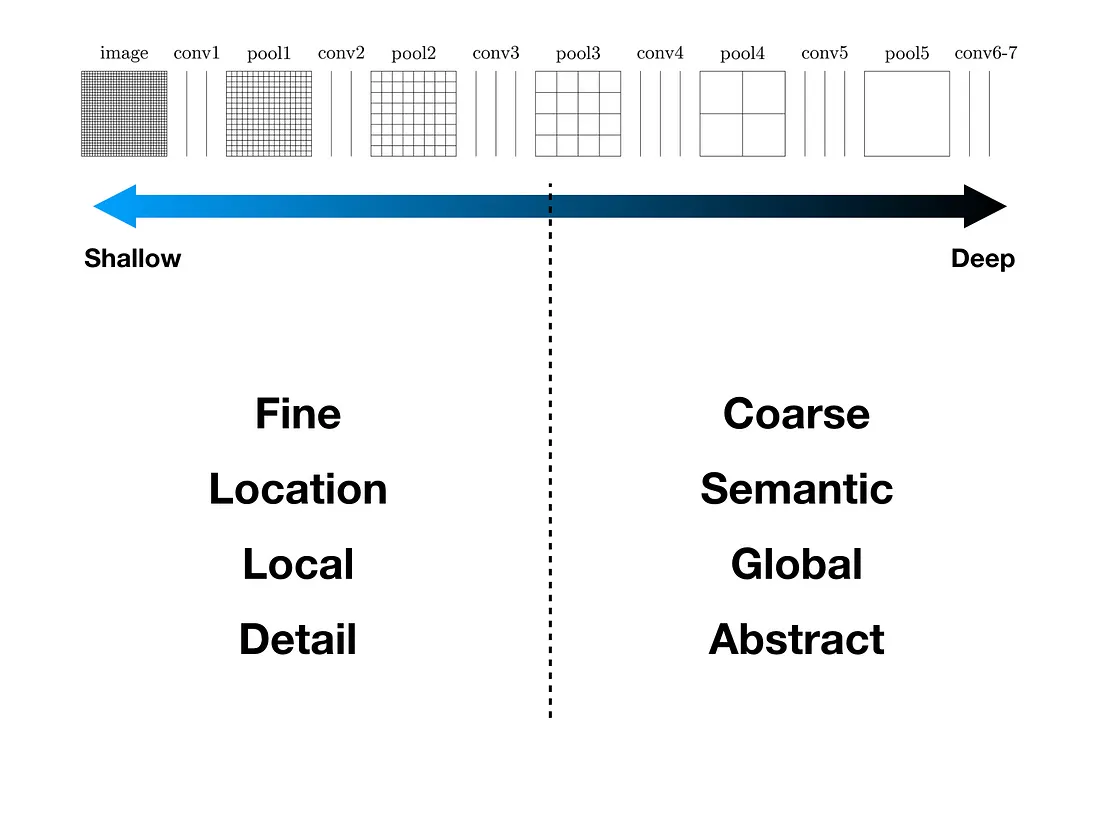

### 네트워크의 구조

#### The Contracting Path

3x3 Conv를 두번씩 반복(패딩없음)</br>
활성화 함수 : ReLU</br>
2x2 max Pooling(stride:2)</br>
Down-sampling마다 채널을 2배 늘림</br>

#### Expanding Path
축소과정을 모두 반대로 함</br>
2x2 convolution (“up-convolution”)</br>
3x3 convolutions을 두 차례씩 반복 (패딩 없음)</br>
Up-Conv를 통한 Up-sampling 마다 채널의 수를 반으로 줄임</br>
활성화 함수는 ReLU</br>
마지막 레이어에 1x1 convolution 연산</br>

최종 레이어의 개수는 23층의 FCN구조

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


수축단계, 팽창단계에 속하는 `conv_block`, `upconv_block`를 먼저 만듬
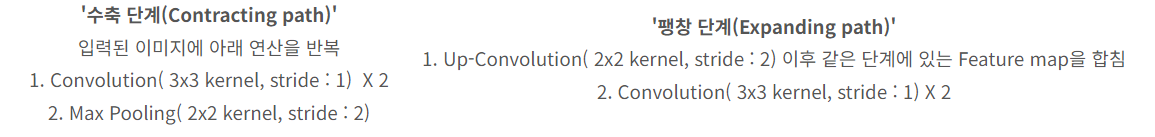

In [2]:
import torchvision.transforms as transforms

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)  # Dropout 추가

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        before_pool = x
        x = self.maxpool(x)
        x = self.dropout(x)  # Dropout 적용

        return x, before_pool #conv는 max pool을 지나기 전 레이어도 출력해줘야함
    
class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvBlock, self).__init__()

        self.convTr = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)  # Dropout 추가

    def forward(self, x, skip):
        x = self.convTr(x)
        #---------여기는 설명이 필요하다----------#
        crop_transform = transforms.CenterCrop((x.shape[2], x.shape[3]))
        skip = crop_transform(skip)
        #---------여기는 설명이 필요하다----------#
        x = torch.cat((x, skip), dim=1) #스킵커넥션
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)  # Dropout 적용

        return x


`x.shape[2]`와 `x.shape[3]` : `ConvTranspose2d`으로 업 샘플링된</br>
텐서 자료형 `x`의 높이, 너비

-> 즉, x의 높이 너비에 맞게 받아온 이미지를 중앙점을 기준으로 crop 하라는 뜻


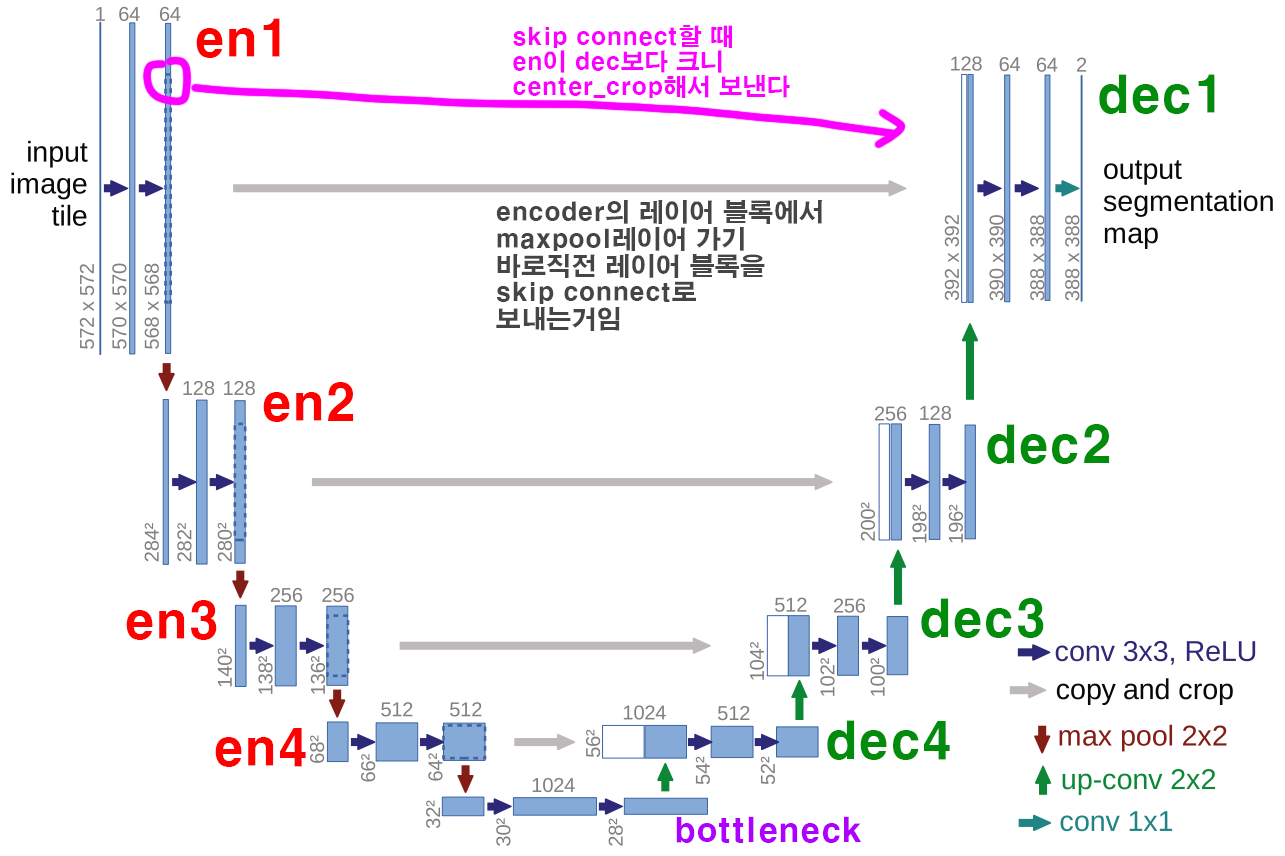
이제 이 구조를 완성시켜보자

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = ConvBlock(in_channels, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)

        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)

        # Decoder
        self.dec4 = UpConvBlock(1024, 512)
        self.dec3 = UpConvBlock(512, 256)
        self.dec2 = UpConvBlock(256, 128)
        self.dec1 = UpConvBlock(128, 64)

        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    
    def forward(self, x):
        #Contracting path 단계
        #before_pool은 디코더로 스킵커낵션 하라고 보내는거
        enc1, before_pool1 = self.enc1(x)
        enc2, before_pool2 = self.enc2(enc1)
        enc3, before_pool3 = self.enc3(enc2)
        enc4, before_pool4 = self.enc4(enc3)

        # Bottleneck
        bottleneck, _ = self.bottleneck(enc4)


        #Expanding path 단계
        #인코더의 before_pool을 스킵커낵션으로 받아서 같이 연산
        dec4 = self.dec4(bottleneck, before_pool4)
        dec3 = self.dec3(dec4, before_pool3)
        dec2 = self.dec2(dec3, before_pool2)
        dec1 = self.dec1(dec2, before_pool1)

        # Output layer
        output = self.out_conv(dec1)

        return output

In [4]:
#모델이 잘 설계되었는지 검증하는 부분
from torchsummary import summary #설계한 모델의 요약본 출력 모듈

debug_model = UNet()
summary(debug_model, input_size=(3, 572, 572), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 572, 572]           1,728
       BatchNorm2d-2         [-1, 64, 572, 572]             128
              ReLU-3         [-1, 64, 572, 572]               0
            Conv2d-4         [-1, 64, 572, 572]          36,864
       BatchNorm2d-5         [-1, 64, 572, 572]             128
              ReLU-6         [-1, 64, 572, 572]               0
         MaxPool2d-7         [-1, 64, 286, 286]               0
           Dropout-8         [-1, 64, 286, 286]               0
         ConvBlock-9  [[-1, 64, 286, 286], [-1, 64, 572, 572]]               0
           Conv2d-10        [-1, 128, 286, 286]          73,728
      BatchNorm2d-11        [-1, 128, 286, 286]             256
             ReLU-12        [-1, 128, 286, 286]               0
           Conv2d-13        [-1, 128, 286, 286]         147,456
      BatchNorm2d-14    

c:\Users\Z13_ASH\AppData\Local\Programs\Python\Python38\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])


### 데이터셋 불러오기
U-Net: Convolutional Networks for Biomedical Image Segmentation
</br>논문에서 사용한 데이터셋은 2개이다.

1. **ISBI EM Segmentation Challenge 데이터셋**:
   - 이 데이터셋은 전자현미경 이미지를 포함하고 있습니다.
   - 구체적으로, Drosophila(초파리) 첫 번째 영양단계 유충의 복부 신경 코드(VNC)의 연속 절단 전자현미경 이미지 30장(각각 512x512 픽셀 크기)으로 구성되어 있습니다.
   - 각 이미지에는 세포(흰색)와 막(검정색)에 대한 완전하게 주석이 달린 정답 세분화 맵이 포함되어 있습니다.

2. **ISBI Cell Tracking Challenge 2015 데이터셋**:
   - U-Net은 또한 이 도전에서 테스트되었으며, 여기에는 위상차 및 미분 간섭 대비(DIC) 현미경 이미지를 포함한 투과광 현미경 이미지가 포함됩니다.
   - 이 데이터셋은 세포의 분할 및 추적 성능을 입증하기 위해 사용되었습니다.


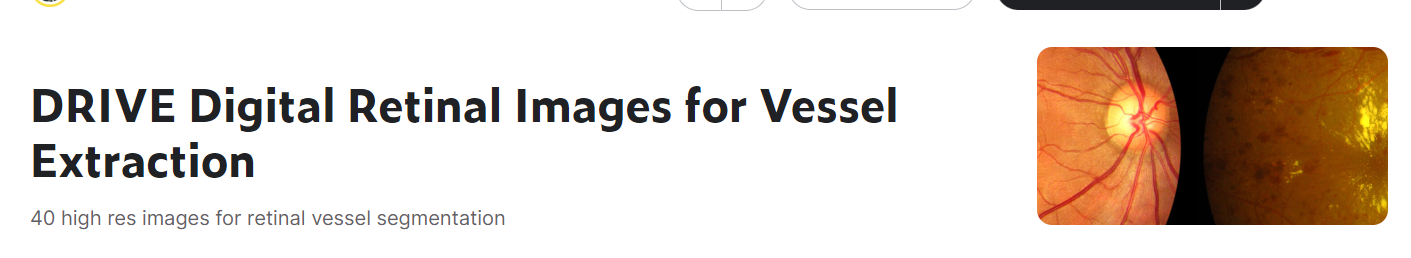
</br>훈련용 데이터셋은 위 이미지의 데이터를 사용한다...

In [5]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

##여기는 데이터셋 증강기법을 사용하기 위한 라이브러리
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, RandomRotate90, Transpose, ShiftScaleRotate,
    ElasticTransform, GridDistortion, OpticalDistortion, RandomBrightnessContrast, Normalize
)
from albumentations.pytorch import ToTensorV2
from PIL import Image

In [6]:
class DRIVEDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")

        mask = Image.open(mask_path)
        mask = mask.convert("L")  # 흑백 이미지로 변환

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_np = np.array(mask)

        image_resized = cv2.resize(image_rgb, (512, 512))
        mask_resized = cv2.resize(mask_np, (512, 512))

        # Normalize the mask to range [0, 1]
        mask_resized = mask_resized / 255.0

        if self.transform:
            augmented = self.transform(image=image_resized, mask=mask_resized)
            image_resized = augmented['image']
            mask_resized = augmented['mask']

        return image_resized, mask_resized

In [7]:
# 데이터 증강 설정
transform = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomRotate90(p=0.5),
    Transpose(p=0.5),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    ElasticTransform(p=0.5),
    GridDistortion(p=0.5),
    OpticalDistortion(p=0.5),
    RandomBrightnessContrast(p=0.5),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# 경로 설정
train_image_dir = './DRIVE/training/images'
train_mask_dir = './DRIVE/training/1st_manual'
test_image_dir = './DRIVE/test/images'
test_mask_dir = './DRIVE/test/mask'

In [8]:
# 경로 표준화를 위해 os.path.normpath 사용
def collect_and_normalize_paths(dir_path, extension):
    file_paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(extension)]
    normalized_paths = [path.replace("\\", "/") for path in file_paths]
    return sorted(normalized_paths)

# 경로 설정
train_image_dir = './DRIVE/training/images'
train_mask_dir = './DRIVE/training/1st_manual'
test_image_dir = './DRIVE/test/images'
test_mask_dir = './DRIVE/test/mask'

# 이미지와 마스크 경로 수집 및 정규화
train_image_paths = collect_and_normalize_paths(train_image_dir, '.tif')
train_mask_paths = collect_and_normalize_paths(train_mask_dir, '.gif')
test_image_paths = collect_and_normalize_paths(test_image_dir, '.tif')
test_mask_paths = collect_and_normalize_paths(test_mask_dir, '.gif')

# 경로 출력 확인
# print("Train image paths:", train_image_paths)
# print("Train mask paths:", train_mask_paths)
# print("Test image paths:", test_image_paths)
# print("Test mask paths:", test_mask_paths)

print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")
print(f"Number of test images: {len(test_image_paths)}")
print(f"Number of test masks: {len(test_mask_paths)}")

Number of training images: 20
Number of training masks: 20
Number of test images: 20
Number of test masks: 20


In [9]:
# 데이터셋 및 데이터로더 생성
train_dataset = DRIVEDataset(train_image_paths, train_mask_paths, transform=transform)
test_dataset = DRIVEDataset(test_image_paths, test_mask_paths, transform=transform)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# CUDA가 사용 가능한 경우, 추가 정보 출력
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Capability: {torch.cuda.get_device_capability(0)}")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / (1024 ** 3):.2f} GB")  # GB 단위로 변환
    print(f"Number of GPUs: {torch.cuda.device_count()}")

cuda
GPU Name: NVIDIA GeForce RTX 4090 Laptop GPU
GPU Capability: (8, 9)
Total Memory: 15.99 GB
Number of GPUs: 1


In [11]:
ex_model = UNet(in_channels=3, out_channels=1)
ex_model.to(device)


# # 가중치 초기화 함수 정의
# def weights_init(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#         nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
#     elif isinstance(m, nn.BatchNorm2d):
#         nn.init.constant_(m.weight, 1)
#         nn.init.constant_(m.bias, 0)

# # 모델에 가중치 초기화 함수 적용
# ex_model.apply(weights_init)


summary(ex_model, input_size=(3, 512, 512), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,728
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,864
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
         MaxPool2d-7         [-1, 64, 256, 256]               0
           Dropout-8         [-1, 64, 256, 256]               0
         ConvBlock-9  [[-1, 64, 256, 256], [-1, 64, 512, 512]]               0
           Conv2d-10        [-1, 128, 256, 256]          73,728
      BatchNorm2d-11        [-1, 128, 256, 256]             256
             ReLU-12        [-1, 128, 256, 256]               0
           Conv2d-13        [-1, 128, 256, 256]         147,456
      BatchNorm2d-14    

### 손실함수, 옵티마이저 정의

Binary Cross-Entropy Loss (BCE Loss): 논문에서는 두 클래스 (즉, 세포와 배경) 사이의 분할을 위한 바이너리 크로스 엔트로피 손실을 사용

Stochastic Gradient Descent (SGD): 논문에서는 SGD를 사용
- Learning Rate: 학습률은 0.01로 설정
- Momentum: 모멘텀은 0.9로 설정

In [12]:
# import torch.optim as optim
# # 손실 함수 정의
# criterion = nn.BCEWithLogitsLoss()
# # 옵티마이저 정의
# optimizer = optim.SGD(ex_model.parameters(), lr=0.01, momentum=0.9)

In [13]:
import torch.optim as optim

# 클래스 가중치 설정
class_weights = torch.tensor([0.8]).to(device)  # Single value for binary classification
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Assuming ex_model is already created and moved to the correct device
optimizer = optim.Adam(ex_model.parameters(), lr=1e-5)


## 훈련, 평가 함수 정의
U-net은 Accuracy는 계산하지 않고 </br>
Dice Coefficient, Intersection over Union (IoU), Precision, Recall
등으로 평가한다.

In [14]:
def dice_coefficient(pred, target, smooth=1.0):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    
    return dice.mean()

def iou(pred, target, smooth=1.0):
    pred = pred > 0.5
    target = target > 0.5

    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.mean()

In [15]:
epoch_step = 10

from tqdm import tqdm

def model_train(model, data_loader, loss_fn, optimizer_fn, processing_device, epoch, output_size=(512, 512)):
    model.train()  # 모델을 훈련 모드로 설정

    global epoch_step
    run_size, run_loss = 0, 0  # accuracy는 계산 안함

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        progress_bar = tqdm(data_loader)
    else:
        progress_bar = data_loader

    for image, mask in progress_bar:
        # 입력된 데이터를 먼저 GPU로 이전하기
        image = image.to(processing_device)
        
        # 모델 출력에 맞게 크기 조정
        mask = mask.to(processing_device).unsqueeze(1).float()
        # 모델 출력 크기에 맞게 마스크 리사이즈
        mask = torch.nn.functional.interpolate(mask, size=output_size, mode='nearest')

        # forward
        output = model(image)
        
        # Ensure the output and mask have the same shape
        output = torch.nn.functional.interpolate(output, size=output_size, mode='nearest')

        # Debugging: Print model outputs and target masks
        # print(f"Model output shape: {output.shape}")
        # print(f"Target mask shape: {mask.shape}")

        # Sigmoid 적용 전과 후의 손실 함수를 비교하여 올바른 것을 사용
        loss = loss_fn(output, mask)

        # backward
        optimizer_fn.zero_grad()
        loss.backward()
        optimizer_fn.step()

        # loss 계산하기
        run_loss += loss.item() * image.size(0)
        run_size += image.size(0)

        # tqdm bar에 추가 정보 기입
        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            progress_bar.set_description('[Training] loss: ' + f'{run_loss / run_size:.4f}')

    avg_loss = run_loss / len(data_loader.dataset)

    return avg_loss


In [16]:
def model_evaluate(model, data_loader, loss_fn, processing_device, epoch, output_size=(256, 256)):
    model.eval()  # 모델을 평가 모드로 전환

    epoch_step = 10

    with torch.no_grad():
        run_loss = 0
        run_dice = 0
        run_iou = 0

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            progress_bar = tqdm(data_loader)
        else:
            progress_bar = data_loader

        for image, mask in progress_bar:
            # 입력된 데이터를 먼저 GPU로 이전하기
            image = image.to(processing_device)
            
            # 모델 출력에 맞게 크기 조정
            mask = mask.to(processing_device).unsqueeze(1).float()
            # 모델 출력 크기에 맞게 마스크 리사이즈
            mask = torch.nn.functional.interpolate(mask, size=output_size, mode='nearest')

            # 평가(forward)
            output = model(image)
            output = torch.sigmoid(output)  # 출력에 sigmoid 적용
            output = (output > 0.5).float()  # 0.5를 기준으로 이진화

            # Debugging: Print model outputs and target masks
            # print(f"Model output min: {output.min().item()}, max: {output.max().item()}")
            # print(f"Target mask min: {mask.min().item()}, max: {mask.max().item()}")

            loss = loss_fn(output, mask)

            run_loss += loss.item() * image.size(0)
            run_dice += dice_coefficient(output, mask).item() * image.size(0)
            run_iou += iou(output, mask).item() * image.size(0)

        avg_loss = run_loss / len(data_loader.dataset)
        avg_dice = run_dice / len(data_loader.dataset)
        avg_iou = run_iou / len(data_loader.dataset)

        return avg_loss, avg_dice, avg_iou


### 실행 및 결과확인

In [17]:
# 학습과 검증 손실 및 정확도를 저장할 리스트
his_loss, his_dice, his_iou = [], [], []

num_epoch = 150

for epoch in range(num_epoch):
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss = model_train(ex_model, train_loader, criterion, optimizer, device, epoch)
    print(f"epoch {epoch+1:03d}, Training loss: {train_loss:.4f}")

    # 검증 손실과 검증 Dice Coefficient 및 IoU를 반환 받습니다.
    val_loss, val_dice, val_iou = model_evaluate(ex_model, test_loader, criterion, device, epoch)
    print(f"Validation loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}")

    # 손실과 정확도를 리스트에 저장
    his_loss.append((train_loss, val_loss))
    his_dice.append(val_dice)
    his_iou.append(val_iou)

[Training] loss: 0.6515: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]


epoch 001, Training loss: 0.6515


100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


Validation loss: 0.5967, Validation Dice: 0.0002, Validation IoU: 0.0578
epoch 002, Training loss: 0.6463
Validation loss: 0.5492, Validation Dice: 0.8026, Validation IoU: 0.6859
epoch 003, Training loss: 0.6442
Validation loss: 0.5904, Validation Dice: 0.8066, Validation IoU: 0.6805
epoch 004, Training loss: 0.6431
Validation loss: 0.5693, Validation Dice: 0.8172, Validation IoU: 0.6947
epoch 005, Training loss: 0.6397
Validation loss: 0.5562, Validation Dice: 0.8289, Validation IoU: 0.7116
epoch 006, Training loss: 0.6374
Validation loss: 0.5924, Validation Dice: 0.7988, Validation IoU: 0.6662
epoch 007, Training loss: 0.6361
Validation loss: 0.5605, Validation Dice: 0.7924, Validation IoU: 0.6464
epoch 008, Training loss: 0.6322
Validation loss: 0.5926, Validation Dice: 0.7043, Validation IoU: 0.5372
epoch 009, Training loss: 0.6319
Validation loss: 0.5736, Validation Dice: 0.6426, Validation IoU: 0.4834


[Training] loss: 0.6298: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


epoch 010, Training loss: 0.6298


100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


Validation loss: 0.5693, Validation Dice: 0.4999, Validation IoU: 0.3882
epoch 011, Training loss: 0.6266
Validation loss: 0.5629, Validation Dice: 0.4387, Validation IoU: 0.3327
epoch 012, Training loss: 0.6263
Validation loss: 0.5781, Validation Dice: 0.3973, Validation IoU: 0.2938
epoch 013, Training loss: 0.6239
Validation loss: 0.5589, Validation Dice: 0.4836, Validation IoU: 0.3620
epoch 014, Training loss: 0.6227
Validation loss: 0.5559, Validation Dice: 0.4201, Validation IoU: 0.3025
epoch 015, Training loss: 0.6226
Validation loss: 0.5765, Validation Dice: 0.3359, Validation IoU: 0.2300
epoch 016, Training loss: 0.6162
Validation loss: 0.5935, Validation Dice: 0.2207, Validation IoU: 0.1468
epoch 017, Training loss: 0.6118
Validation loss: 0.5925, Validation Dice: 0.1682, Validation IoU: 0.1079
epoch 018, Training loss: 0.6075
Validation loss: 0.5960, Validation Dice: 0.1501, Validation IoU: 0.0991
epoch 019, Training loss: 0.6040
Validation loss: 0.5968, Validation Dice: 0.09

[Training] loss: 0.5946: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


epoch 020, Training loss: 0.5946


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Validation loss: 0.5996, Validation Dice: 0.0804, Validation IoU: 0.0603
epoch 021, Training loss: 0.6040
Validation loss: 0.5938, Validation Dice: 0.0728, Validation IoU: 0.0551
epoch 022, Training loss: 0.5873
Validation loss: 0.6007, Validation Dice: 0.0591, Validation IoU: 0.0577
epoch 023, Training loss: 0.5794
Validation loss: 0.6013, Validation Dice: 0.0481, Validation IoU: 0.0577
epoch 024, Training loss: 0.5747
Validation loss: 0.6015, Validation Dice: 0.0184, Validation IoU: 0.0509
epoch 025, Training loss: 0.5774
Validation loss: 0.5970, Validation Dice: 0.0177, Validation IoU: 0.0392
epoch 026, Training loss: 0.5685
Validation loss: 0.5966, Validation Dice: 0.0153, Validation IoU: 0.0478
epoch 027, Training loss: 0.5683
Validation loss: 0.5959, Validation Dice: 0.0152, Validation IoU: 0.0428
epoch 028, Training loss: 0.5582
Validation loss: 0.5939, Validation Dice: 0.0167, Validation IoU: 0.0362
epoch 029, Training loss: 0.5434
Validation loss: 0.5983, Validation Dice: 0.01

[Training] loss: 0.5471: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


epoch 030, Training loss: 0.5471


100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Validation loss: 0.5948, Validation Dice: 0.0361, Validation IoU: 0.0526
epoch 031, Training loss: 0.5373
Validation loss: 0.5950, Validation Dice: 0.0098, Validation IoU: 0.0394
epoch 032, Training loss: 0.5326
Validation loss: 0.5984, Validation Dice: 0.0126, Validation IoU: 0.0557
epoch 033, Training loss: 0.5432
Validation loss: 0.6007, Validation Dice: 0.0129, Validation IoU: 0.0561
epoch 034, Training loss: 0.5287
Validation loss: 0.5984, Validation Dice: 0.0069, Validation IoU: 0.0499
epoch 035, Training loss: 0.5213
Validation loss: 0.5977, Validation Dice: 0.0067, Validation IoU: 0.0469
epoch 036, Training loss: 0.5424
Validation loss: 0.5962, Validation Dice: 0.0058, Validation IoU: 0.0536
epoch 037, Training loss: 0.5262
Validation loss: 0.5986, Validation Dice: 0.0099, Validation IoU: 0.0642
epoch 038, Training loss: 0.5058
Validation loss: 0.5965, Validation Dice: 0.0064, Validation IoU: 0.0483
epoch 039, Training loss: 0.4923
Validation loss: 0.5975, Validation Dice: 0.01

[Training] loss: 0.5039: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


epoch 040, Training loss: 0.5039


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


Validation loss: 0.5969, Validation Dice: 0.0032, Validation IoU: 0.0590
epoch 041, Training loss: 0.5123
Validation loss: 0.5938, Validation Dice: 0.0061, Validation IoU: 0.0503
epoch 042, Training loss: 0.4999
Validation loss: 0.5965, Validation Dice: 0.0050, Validation IoU: 0.0524
epoch 043, Training loss: 0.4879
Validation loss: 0.5952, Validation Dice: 0.0053, Validation IoU: 0.0565
epoch 044, Training loss: 0.4860
Validation loss: 0.5994, Validation Dice: 0.0038, Validation IoU: 0.0604
epoch 045, Training loss: 0.4814
Validation loss: 0.5974, Validation Dice: 0.0047, Validation IoU: 0.0556
epoch 046, Training loss: 0.4866
Validation loss: 0.5952, Validation Dice: 0.0023, Validation IoU: 0.0564
epoch 047, Training loss: 0.4902
Validation loss: 0.5981, Validation Dice: 0.0026, Validation IoU: 0.0581
epoch 048, Training loss: 0.4846
Validation loss: 0.5954, Validation Dice: 0.0037, Validation IoU: 0.0539
epoch 049, Training loss: 0.4724
Validation loss: 0.5986, Validation Dice: 0.00

[Training] loss: 0.4716: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


epoch 050, Training loss: 0.4716


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Validation loss: 0.5950, Validation Dice: 0.0022, Validation IoU: 0.0645
epoch 051, Training loss: 0.4830
Validation loss: 0.5967, Validation Dice: 0.0010, Validation IoU: 0.0657
epoch 052, Training loss: 0.4733
Validation loss: 0.5964, Validation Dice: 0.0036, Validation IoU: 0.0567
epoch 053, Training loss: 0.4675
Validation loss: 0.6017, Validation Dice: 0.0015, Validation IoU: 0.0723
epoch 054, Training loss: 0.4785
Validation loss: 0.5949, Validation Dice: 0.0027, Validation IoU: 0.0458
epoch 055, Training loss: 0.4644
Validation loss: 0.5959, Validation Dice: 0.0047, Validation IoU: 0.0464
epoch 056, Training loss: 0.4665
Validation loss: 0.5967, Validation Dice: 0.0023, Validation IoU: 0.0524
epoch 057, Training loss: 0.4640
Validation loss: 0.5954, Validation Dice: 0.0041, Validation IoU: 0.0563
epoch 058, Training loss: 0.4599
Validation loss: 0.5943, Validation Dice: 0.0049, Validation IoU: 0.0408
epoch 059, Training loss: 0.4634
Validation loss: 0.5968, Validation Dice: 0.00

[Training] loss: 0.4606: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


epoch 060, Training loss: 0.4606


100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Validation loss: 0.5976, Validation Dice: 0.0046, Validation IoU: 0.0626
epoch 061, Training loss: 0.4520
Validation loss: 0.5946, Validation Dice: 0.0007, Validation IoU: 0.0471
epoch 062, Training loss: 0.4475
Validation loss: 0.5969, Validation Dice: 0.0016, Validation IoU: 0.0689
epoch 063, Training loss: 0.4565
Validation loss: 0.5945, Validation Dice: 0.0004, Validation IoU: 0.0507
epoch 064, Training loss: 0.4460
Validation loss: 0.5984, Validation Dice: 0.0004, Validation IoU: 0.0606
epoch 065, Training loss: 0.4566
Validation loss: 0.5965, Validation Dice: 0.0000, Validation IoU: 0.0508
epoch 066, Training loss: 0.4560
Validation loss: 0.5963, Validation Dice: 0.0009, Validation IoU: 0.0621
epoch 067, Training loss: 0.4472
Validation loss: 0.5987, Validation Dice: 0.0013, Validation IoU: 0.0670
epoch 068, Training loss: 0.4469
Validation loss: 0.5989, Validation Dice: 0.0011, Validation IoU: 0.0544
epoch 069, Training loss: 0.4432
Validation loss: 0.5962, Validation Dice: 0.00

[Training] loss: 0.4403: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


epoch 070, Training loss: 0.4403


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Validation loss: 0.5981, Validation Dice: 0.0005, Validation IoU: 0.0633
epoch 071, Training loss: 0.4505
Validation loss: 0.5971, Validation Dice: 0.0008, Validation IoU: 0.0449
epoch 072, Training loss: 0.4380
Validation loss: 0.5960, Validation Dice: 0.0004, Validation IoU: 0.0402
epoch 073, Training loss: 0.4407
Validation loss: 0.5967, Validation Dice: 0.0005, Validation IoU: 0.0732
epoch 074, Training loss: 0.4505
Validation loss: 0.5998, Validation Dice: 0.0005, Validation IoU: 0.0647
epoch 075, Training loss: 0.4400
Validation loss: 0.5982, Validation Dice: 0.0002, Validation IoU: 0.0528
epoch 076, Training loss: 0.4312
Validation loss: 0.5977, Validation Dice: 0.0011, Validation IoU: 0.0592
epoch 077, Training loss: 0.4391
Validation loss: 0.5963, Validation Dice: 0.0008, Validation IoU: 0.0668
epoch 078, Training loss: 0.4353
Validation loss: 0.5971, Validation Dice: 0.0009, Validation IoU: 0.0435
epoch 079, Training loss: 0.4305
Validation loss: 0.5930, Validation Dice: 0.00

[Training] loss: 0.4327: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


epoch 080, Training loss: 0.4327


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Validation loss: 0.5991, Validation Dice: 0.0008, Validation IoU: 0.0598
epoch 081, Training loss: 0.4266
Validation loss: 0.5944, Validation Dice: 0.0010, Validation IoU: 0.0586
epoch 082, Training loss: 0.4269
Validation loss: 0.5947, Validation Dice: 0.0011, Validation IoU: 0.0577
epoch 083, Training loss: 0.4258
Validation loss: 0.5981, Validation Dice: 0.0003, Validation IoU: 0.0510
epoch 084, Training loss: 0.4286
Validation loss: 0.5969, Validation Dice: 0.0022, Validation IoU: 0.0688
epoch 085, Training loss: 0.4220
Validation loss: 0.5954, Validation Dice: 0.0003, Validation IoU: 0.0479
epoch 086, Training loss: 0.4212
Validation loss: 0.5979, Validation Dice: 0.0001, Validation IoU: 0.0637
epoch 087, Training loss: 0.4241
Validation loss: 0.5995, Validation Dice: 0.0000, Validation IoU: 0.0581
epoch 088, Training loss: 0.4292
Validation loss: 0.5996, Validation Dice: 0.0004, Validation IoU: 0.0675
epoch 089, Training loss: 0.4249
Validation loss: 0.5960, Validation Dice: 0.00

[Training] loss: 0.4161: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


epoch 090, Training loss: 0.4161


100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Validation loss: 0.5971, Validation Dice: 0.0019, Validation IoU: 0.0533
epoch 091, Training loss: 0.4219
Validation loss: 0.5993, Validation Dice: 0.0001, Validation IoU: 0.0705
epoch 092, Training loss: 0.4208
Validation loss: 0.5990, Validation Dice: 0.0004, Validation IoU: 0.0577
epoch 093, Training loss: 0.4182
Validation loss: 0.5986, Validation Dice: 0.0000, Validation IoU: 0.0772
epoch 094, Training loss: 0.4326
Validation loss: 0.5983, Validation Dice: 0.0000, Validation IoU: 0.0685
epoch 095, Training loss: 0.4100
Validation loss: 0.5968, Validation Dice: 0.0013, Validation IoU: 0.0588
epoch 096, Training loss: 0.4219
Validation loss: 0.5961, Validation Dice: 0.0014, Validation IoU: 0.0441
epoch 097, Training loss: 0.4186
Validation loss: 0.5968, Validation Dice: 0.0007, Validation IoU: 0.0607
epoch 098, Training loss: 0.4231
Validation loss: 0.5983, Validation Dice: 0.0003, Validation IoU: 0.0594
epoch 099, Training loss: 0.4124
Validation loss: 0.6003, Validation Dice: 0.00

[Training] loss: 0.4123: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


epoch 100, Training loss: 0.4123


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Validation loss: 0.5956, Validation Dice: 0.0019, Validation IoU: 0.0532
epoch 101, Training loss: 0.4128
Validation loss: 0.6022, Validation Dice: 0.0005, Validation IoU: 0.0649
epoch 102, Training loss: 0.4134
Validation loss: 0.5954, Validation Dice: 0.0000, Validation IoU: 0.0620
epoch 103, Training loss: 0.4160
Validation loss: 0.5897, Validation Dice: 0.0002, Validation IoU: 0.0455
epoch 104, Training loss: 0.4198
Validation loss: 0.5961, Validation Dice: 0.0005, Validation IoU: 0.0559
epoch 105, Training loss: 0.4052
Validation loss: 0.5963, Validation Dice: 0.0000, Validation IoU: 0.0490
epoch 106, Training loss: 0.4105
Validation loss: 0.6011, Validation Dice: 0.0003, Validation IoU: 0.0703
epoch 107, Training loss: 0.4143
Validation loss: 0.5987, Validation Dice: 0.0000, Validation IoU: 0.0672
epoch 108, Training loss: 0.4068
Validation loss: 0.5927, Validation Dice: 0.0004, Validation IoU: 0.0602
epoch 109, Training loss: 0.4083
Validation loss: 0.5989, Validation Dice: 0.00

[Training] loss: 0.4051: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


epoch 110, Training loss: 0.4051


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Validation loss: 0.5963, Validation Dice: 0.0007, Validation IoU: 0.0503
epoch 111, Training loss: 0.4238
Validation loss: 0.5998, Validation Dice: 0.0000, Validation IoU: 0.0681
epoch 112, Training loss: 0.4085
Validation loss: 0.5986, Validation Dice: 0.0002, Validation IoU: 0.0567
epoch 113, Training loss: 0.4062
Validation loss: 0.5995, Validation Dice: 0.0001, Validation IoU: 0.0580
epoch 114, Training loss: 0.4061
Validation loss: 0.5962, Validation Dice: 0.0004, Validation IoU: 0.0648
epoch 115, Training loss: 0.4048
Validation loss: 0.5979, Validation Dice: 0.0000, Validation IoU: 0.0612
epoch 116, Training loss: 0.4027
Validation loss: 0.5973, Validation Dice: 0.0004, Validation IoU: 0.0531
epoch 117, Training loss: 0.4041
Validation loss: 0.5955, Validation Dice: 0.0003, Validation IoU: 0.0762
epoch 118, Training loss: 0.4010
Validation loss: 0.5996, Validation Dice: 0.0000, Validation IoU: 0.0630
epoch 119, Training loss: 0.4026
Validation loss: 0.5931, Validation Dice: 0.00

[Training] loss: 0.4028: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch 120, Training loss: 0.4028


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Validation loss: 0.6023, Validation Dice: 0.0005, Validation IoU: 0.0775
epoch 121, Training loss: 0.4121
Validation loss: 0.5967, Validation Dice: 0.0004, Validation IoU: 0.0482
epoch 122, Training loss: 0.4022
Validation loss: 0.6002, Validation Dice: 0.0000, Validation IoU: 0.0756
epoch 123, Training loss: 0.4045
Validation loss: 0.5977, Validation Dice: 0.0000, Validation IoU: 0.0728
epoch 124, Training loss: 0.4016
Validation loss: 0.5910, Validation Dice: 0.0000, Validation IoU: 0.0474
epoch 125, Training loss: 0.4011
Validation loss: 0.5957, Validation Dice: 0.0000, Validation IoU: 0.0605
epoch 126, Training loss: 0.4065
Validation loss: 0.5985, Validation Dice: 0.0000, Validation IoU: 0.0687
epoch 127, Training loss: 0.3989
Validation loss: 0.5961, Validation Dice: 0.0000, Validation IoU: 0.0583
epoch 128, Training loss: 0.3954
Validation loss: 0.5980, Validation Dice: 0.0000, Validation IoU: 0.0632
epoch 129, Training loss: 0.3996
Validation loss: 0.5947, Validation Dice: 0.00

[Training] loss: 0.3995: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


epoch 130, Training loss: 0.3995


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Validation loss: 0.5979, Validation Dice: 0.0000, Validation IoU: 0.0681
epoch 131, Training loss: 0.4006
Validation loss: 0.5948, Validation Dice: 0.0000, Validation IoU: 0.0585
epoch 132, Training loss: 0.4028
Validation loss: 0.5952, Validation Dice: 0.0000, Validation IoU: 0.0524
epoch 133, Training loss: 0.3886
Validation loss: 0.6028, Validation Dice: 0.0001, Validation IoU: 0.0631
epoch 134, Training loss: 0.3986
Validation loss: 0.6001, Validation Dice: 0.0000, Validation IoU: 0.0692
epoch 135, Training loss: 0.3980
Validation loss: 0.5936, Validation Dice: 0.0000, Validation IoU: 0.0491
epoch 136, Training loss: 0.3932
Validation loss: 0.5974, Validation Dice: 0.0000, Validation IoU: 0.0527
epoch 137, Training loss: 0.3944
Validation loss: 0.5981, Validation Dice: 0.0000, Validation IoU: 0.0463
epoch 138, Training loss: 0.3957
Validation loss: 0.5969, Validation Dice: 0.0000, Validation IoU: 0.0681
epoch 139, Training loss: 0.3949
Validation loss: 0.5967, Validation Dice: 0.00

[Training] loss: 0.3916: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


epoch 140, Training loss: 0.3916


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Validation loss: 0.5973, Validation Dice: 0.0000, Validation IoU: 0.0492
epoch 141, Training loss: 0.3933
Validation loss: 0.5979, Validation Dice: 0.0000, Validation IoU: 0.0696
epoch 142, Training loss: 0.3952
Validation loss: 0.5965, Validation Dice: 0.0002, Validation IoU: 0.0501
epoch 143, Training loss: 0.3913
Validation loss: 0.5986, Validation Dice: 0.0000, Validation IoU: 0.0607
epoch 144, Training loss: 0.3916
Validation loss: 0.6010, Validation Dice: 0.0000, Validation IoU: 0.0814
epoch 145, Training loss: 0.3897
Validation loss: 0.5944, Validation Dice: 0.0000, Validation IoU: 0.0608
epoch 146, Training loss: 0.3919
Validation loss: 0.5973, Validation Dice: 0.0005, Validation IoU: 0.0610
epoch 147, Training loss: 0.3867
Validation loss: 0.5959, Validation Dice: 0.0000, Validation IoU: 0.0536
epoch 148, Training loss: 0.3972
Validation loss: 0.5976, Validation Dice: 0.0000, Validation IoU: 0.0486
epoch 149, Training loss: 0.3928
Validation loss: 0.6001, Validation Dice: 0.00

[Training] loss: 0.4041: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


epoch 150, Training loss: 0.4041


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

Validation loss: 0.5941, Validation Dice: 0.0001, Validation IoU: 0.0604


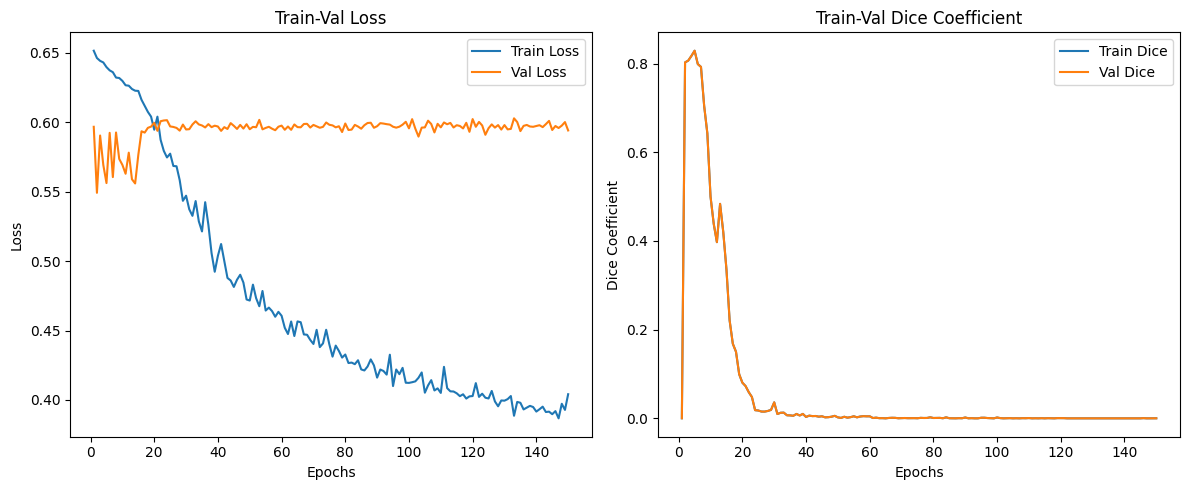

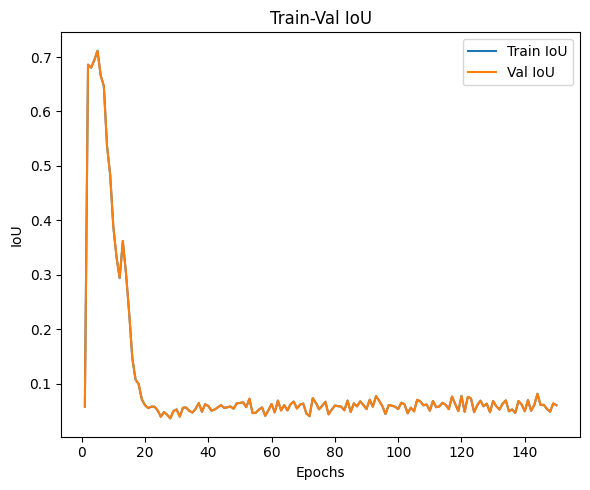

In [18]:
import matplotlib.pyplot as plt

# 시각화
train_losses, val_losses = zip(*his_loss)
epochs = range(1, num_epoch + 1)

# 손실 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train-Val Loss')
plt.legend()

# Dice Coefficient 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, his_dice, label='Train Dice')
plt.plot(epochs, his_dice, label='Val Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Train-Val Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()

# IoU 그래프
plt.figure(figsize=(6, 5))
plt.plot(epochs, his_iou, label='Train IoU')
plt.plot(epochs, his_iou, label='Val IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Train-Val IoU')
plt.legend()

plt.tight_layout()
plt.show()

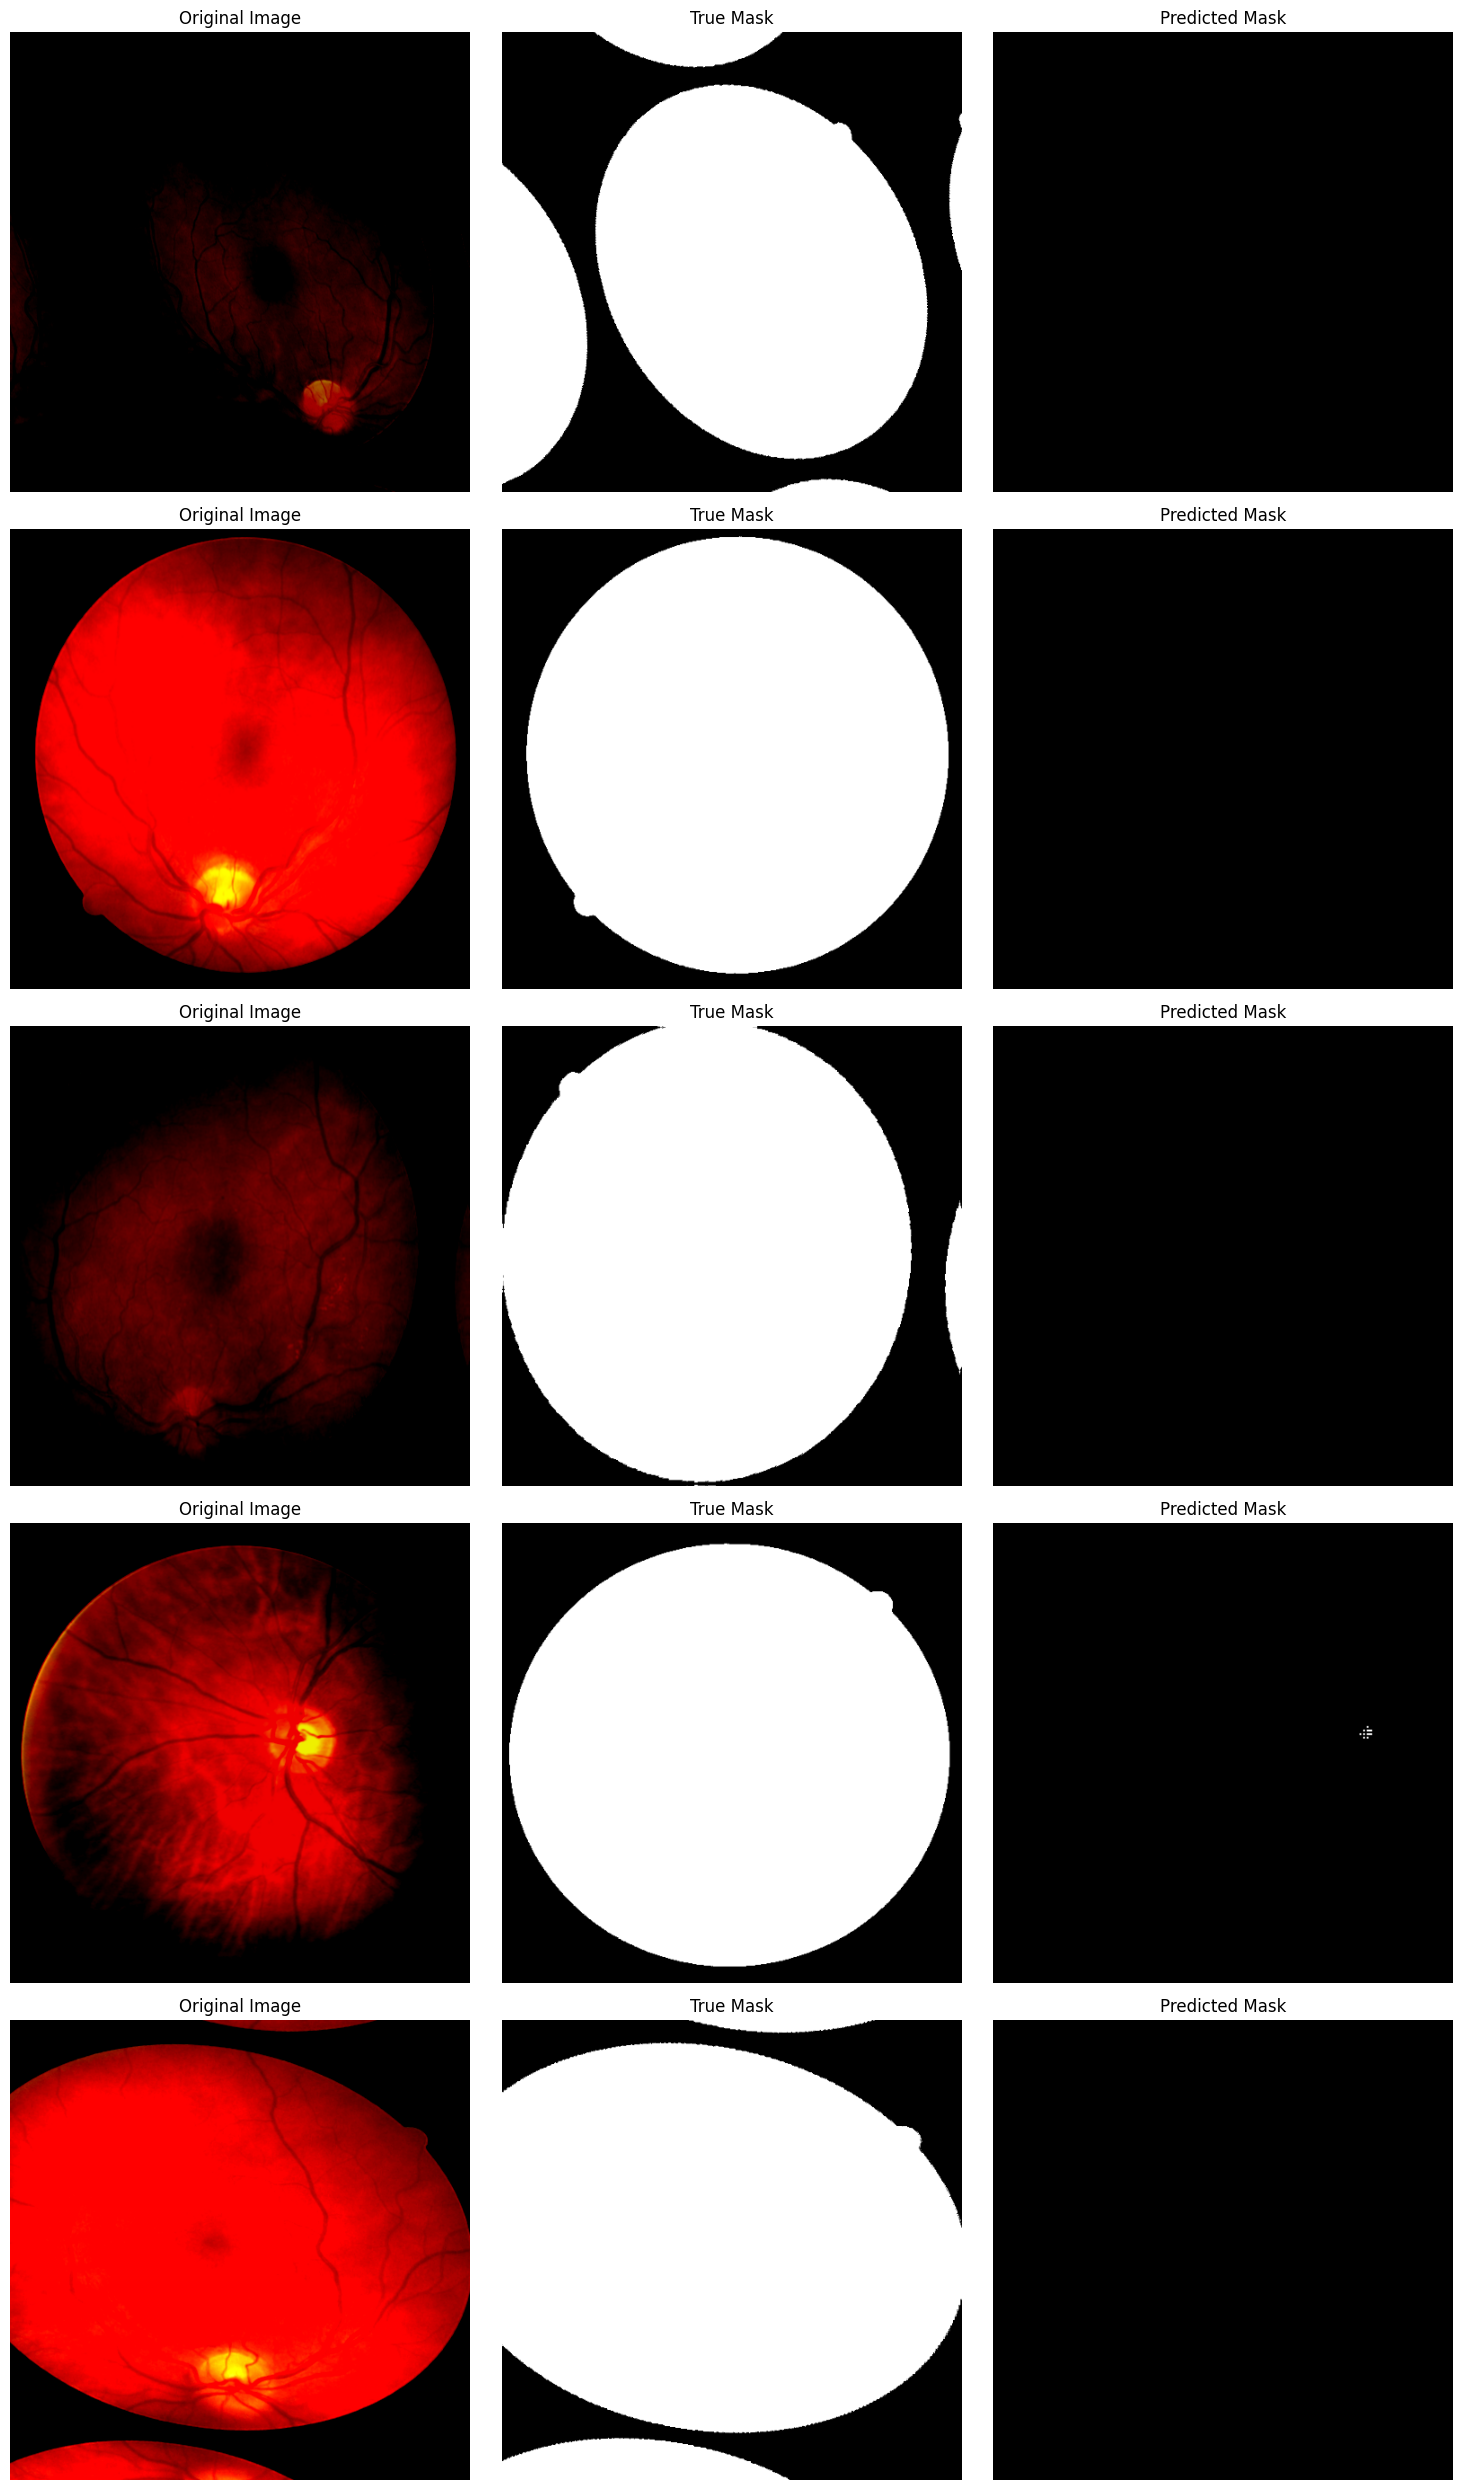

In [19]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, device, num_samples=5):
    model.eval()
    images, true_masks, pred_masks = [], [], []
    
    with torch.no_grad():
        for image, mask in data_loader:
            image = image.to(device)
            mask = mask.to(device).unsqueeze(1).float()
            
            # 모델 예측
            output = model(image)
            output = torch.sigmoid(output)  # 시그모이드 적용
            pred = (output > 0.5).float()  # 0.5를 기준으로 이진화
            
            images.extend(image.cpu())
            true_masks.extend(mask.cpu())
            pred_masks.extend(pred.cpu())
            
            if len(images) >= num_samples:
                break
    
    images = images[:num_samples]
    true_masks = true_masks[:num_samples]
    pred_masks = pred_masks[:num_samples]
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i].permute(1, 2, 0))
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(true_masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("True Mask")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_masks[i].squeeze(), cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# 임의의 데이터/마스크 및 모델 예측 시각화
visualize_predictions(ex_model, test_loader, device, num_samples=5)